# Travel Data Quest  

### Description:  
You're a data scientist at a leading travel company, and you've been tasked with analyzing customer booking behavior to inform marketing strategies. Your team has collected data on customer bookings, including demographics, travel dates, and accommodation types. However, the data is scattered across multiple sources and needs to be cleaned, merged, and transformed before analysis can begin.  

### Tasks:  
- **Merge:** Combine the customer demographics and booking data into a single DataFrame.
- **Feature Engineering:** Take the merged data from Task #1 and reshape it to create a customer-centric view.
- **Group and Aggregate:** Group the data by region and accommodation type, and calculate key metrics such as total booking value, average booking value, and count of bookings. Then, sort and rank the results to identify top-performing regions and accommodation types.

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)

Python version 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Pandas version 2.2.1
Numpy version 1.26.4


# The Data  

The data is designed to mimic real-world travel industry data, with a focus on customer booking behavior and preferences.  

**customer_demographics:**    
- customer_id (unique identifier)
- age (integer)
- region (categorical)

**booking_data:**    
- booking_id (unique identifier)
- customer_id (foreign key referencing customer_demographics)
- travel_date (datetime)
- accommodation_type (categorical)
- booking_value (integer)
- booking_status (categorical)

In [2]:
# set the seed
np.random.seed(0)

# customer demographics
customer_demographics = pd.DataFrame({
    'customer_id': np.arange(1, 10001),
    'age': np.random.randint(18, 65, 10000),
    'region': np.random.choice(['North', 'South', 'East', 'West'], 10000)
})

# booking data
booking_data = pd.DataFrame({
    'booking_id': np.arange(1, 50001),
    'customer_id': np.random.randint(1, 10000, 50000),
    'travel_date': pd.date_range('2022-01-01', periods=50000),
    'accommodation_type': np.random.choice(['Hotel', 'Hostel', 'Vacation Rental'], 50000)
})

# additional columns
booking_data['booking_value'] = np.random.randint(100, 1000, 50000)
booking_data['booking_status'] = np.random.choice(['Confirmed', 'Cancelled'], 50000)

Let us make sure the data types are correct for both of the dataframes.

In [3]:
customer_demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  10000 non-null  int32 
 1   age          10000 non-null  int32 
 2   region       10000 non-null  object
dtypes: int32(2), object(1)
memory usage: 156.4+ KB


And here is the information for the booking_data.

In [4]:
booking_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   booking_id          50000 non-null  int32         
 1   customer_id         50000 non-null  int32         
 2   travel_date         50000 non-null  datetime64[ns]
 3   accommodation_type  50000 non-null  object        
 4   booking_value       50000 non-null  int32         
 5   booking_status      50000 non-null  object        
dtypes: datetime64[ns](1), int32(3), object(2)
memory usage: 1.7+ MB


# Merge:  

Combine the customer demographics and booking data into a single DataFrame.  

For the merge:
- The main dataset is booking_data and any additional columns will come from the customer_demographics dataframe. We accomplish this by using a left join.  
- The common column we will merge on is called "customer_id".  

In [5]:
# merge the dataframes
new_df = booking_data.merge(customer_demographics, how='left', on='customer_id')
new_df.head()

,booking_id,customer_id,travel_date,accommodation_type,booking_value,booking_status,age,region
0,1,3945,2022-01-01,Hotel,964,Confirmed,44,East
1,2,8165,2022-01-02,Hostel,603,Cancelled,55,South
2,3,7863,2022-01-03,Vacation Rental,395,Confirmed,62,South
3,4,6775,2022-01-04,Hostel,566,Cancelled,30,South
4,5,2485,2022-01-05,Hotel,776,Cancelled,24,North


# Feature Engineering

Take the merged data from Task #1 and reshape it to create a customer-centric view.

To reshape the data, let us follow the directions below:  

Use the pivot_table function to create a new DataFrame with the following structure:  

**Index:**  
- customer_id

**Columns:**  
- **age** (from customer_demographics)
- **region** (from customer_demographics)
- **total_bookings** (count of bookings per customer)
- **total_booking_value** (sum of booking values per customer)
- **favorite_accommodation_type** (mode of accommodation types per customer)  

This will create a customer-centric view with summarized booking information for each customer.



In [6]:
pivot = new_df.pivot_table(index='customer_id',
                      values=['booking_id', 'booking_value', 'accommodation_type'],
                      aggfunc={'booking_id': 'count', 
                               'booking_value': 'sum', 
                               'accommodation_type': lambda x: x.mode().iloc[0]})

Now all we need to do is rename the columns.

In [7]:
# the json format makes it easy to rename the columns
pivot = pivot.rename(columns={'booking_id': 'total_bookings', 
                      'booking_value': 'total_booking_value', 
                      'accommodation_type': 'favorite_accommodation_type'})

pivot.head()

,favorite_accommodation_type,total_bookings,total_booking_value
customer_id,,,
1,Hotel,6,2959
2,Hotel,5,3108
3,Vacation Rental,3,2043
4,Vacation Rental,4,2568
5,Hotel,9,3356


# Group and Aggregate

Group the data by region and accommodation type, and calculate key metrics such as total booking value, average booking value, and count of bookings. Then, sort and rank the results to identify top-performing regions and accommodation types.

In [8]:
# create group object
group = new_df.groupby(['region','accommodation_type'])

# calculate total booking value, average booking value, and count of bookings
metrics = group.agg(
     total_booking_value=pd.NamedAgg(column="booking_value", aggfunc="sum"),
     avg_booking_value=pd.NamedAgg(column="booking_value", aggfunc="mean"),
     count_of_bookings=pd.NamedAgg(column="booking_value", aggfunc="count")
)

metrics.head()

total_booking_value  avg_booking_value  \
region accommodation_type                                           
East   Hostel                          2353019         550.542583   
       Hotel                           2320282         545.050975   
       Vacation Rental                 2326865         553.883599   
North  Hostel                          2356863         548.362727   
       Hotel                           2309074         552.674485   

                           count_of_bookings  
region accommodation_type                     
East   Hostel                           4274  
       Hotel                            4257  
       Vacation Rental                  4201  
North  Hostel                           4298  
       Hotel                            4178

We can sort the data to identify which region/accommodation_type had the most bookings.  

According to the data, Hostels in the North region had the highest count of bookings.

In [9]:
metrics.sort_values(by='count_of_bookings', ascending=False)

total_booking_value  avg_booking_value  \
region accommodation_type                                           
North  Hostel                          2356863         548.362727   
East   Hostel                          2353019         550.542583   
       Hotel                           2320282         545.050975   
       Vacation Rental                 2326865         553.883599   
North  Hotel                           2309074         552.674485   
South  Hotel                           2290785         549.744420   
West   Hotel                           2294852         552.443909   
North  Vacation Rental                 2267620         548.529269   
West   Vacation Rental                 2279817         552.013801   
South  Vacation Rental                 2244830         548.188034   
West   Hostel                          2220775         546.988916   
South  Hostel                          2224943         549.097483   

                           count_of_bookings  
region accommodation_type                     
North  Hostel                           4298  
East   Hostel                           4274  
       Hotel                            4257  
       Vacation Rental                  4201  
North  Hotel                            4178  
South  Hotel                            4167  
West   Hotel                            4154  
North  Vacation Rental                  4134  
West   Vacation Rental                  4130  
South  Vacation Rental                  4095  
West   Hostel                           4060  
South  Hostel                           4052

We can also try to plot the data to visually attempt to uncover patterns.  

From the charts below, what I can spot pretty easily is that price is an important factor. We can see places like the East Hotel and the North Hostel have a healthy number of bookings. My best guess is that the low price is convincing people to book. What do you think?

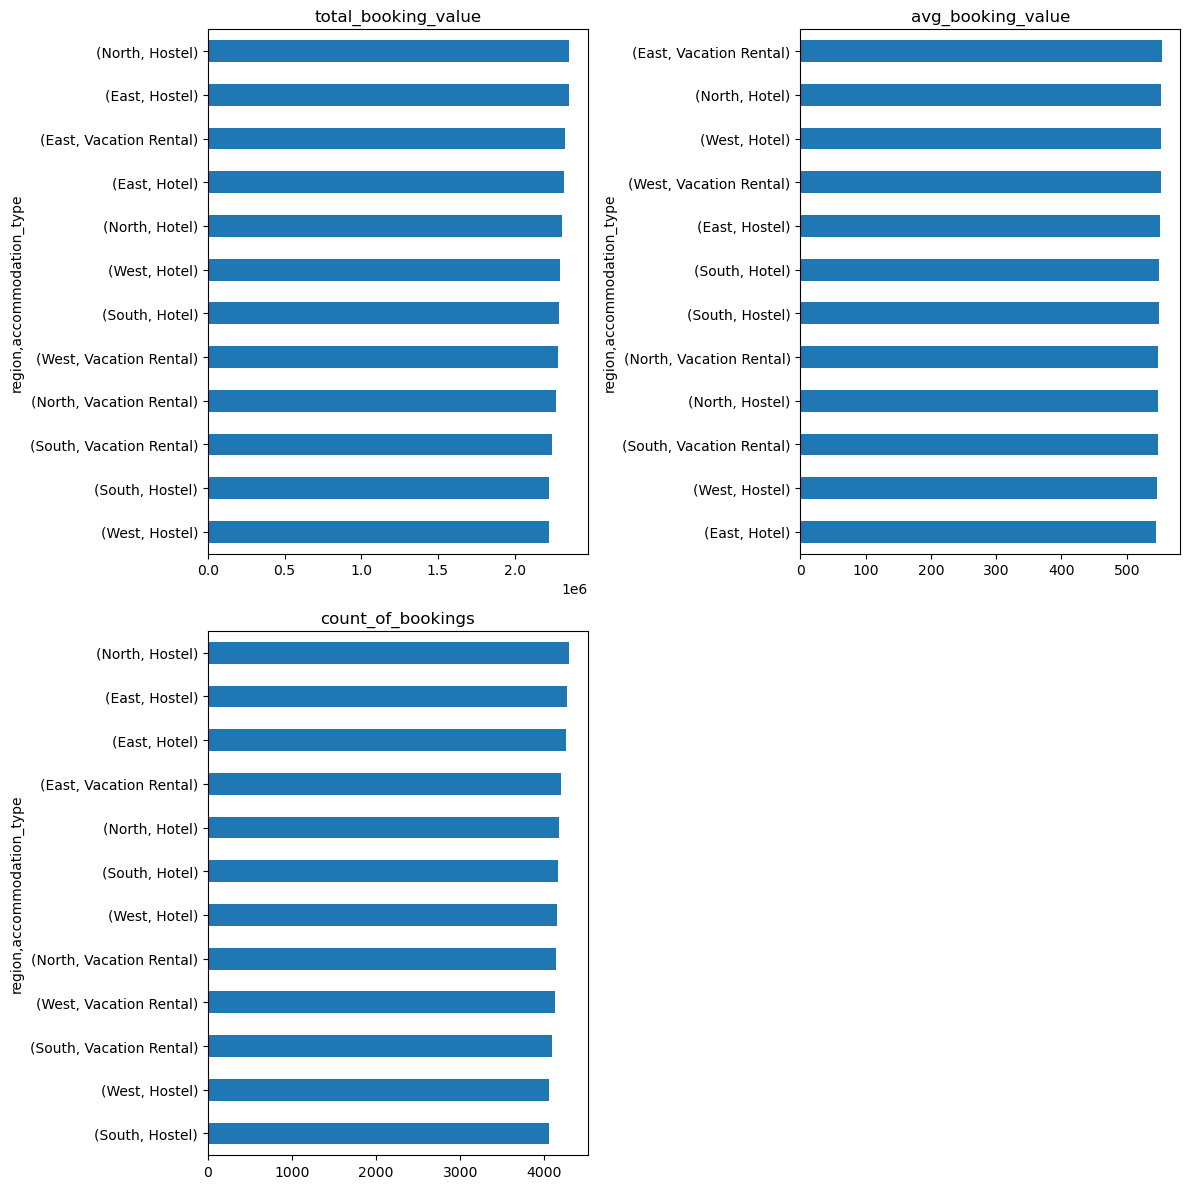

In [10]:
# this section is used to dynamically create the subplot row and column
num_columns = len(metrics.columns)
num_rows = (num_columns + 1) // 2  # we want to only have 2 columns of plots
num_cols = 2

# you can adjust the figsize to your preference here
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12,4*len(metrics.columns)))

# create space between plots
fig.subplots_adjust(hspace=2.0)

# this is to avoid having to deal with dynamically determining the rows,column on the loop below
axs = axs.flatten()

# loop through each column and create a bar chart
for i, column in enumerate(metrics.columns):
    metrics[column].sort_values().plot.barh(ax=axs[i])
    axs[i].set_title(f'{column}')

# hide any unused axes
for i in range(len(metrics.columns), len(axs)):
    axs[i].axis('off')

fig.tight_layout()
plt.show()

# Summary  

This tutorial guides you through analyzing customer booking behavior for a travel company using Pandas, covering tasks such as merging and reshaping data, grouping and aggregating data, and visualizing results to identify trends and patterns. By the end of the tutorial, you'll have a comprehensive understanding of how to clean, transform, and analyze data to inform marketing strategies.

### Key Takeaways:  
- Merging data from multiple sources using `pd.merge()`
- Using `pivot_table()` to reshape data and create a customer-centric view
- Grouping and aggregating data using `groupby()` and `agg()`
- Calculating key metrics such as total booking value, average booking value, and count of bookings
- Sorting and ranking data to identify top-performing regions and accommodation types
- Visualizing data using bar charts to uncover patterns and trends

<p class="text-muted">This tutorial was created by <a href="https://www.hedaro.com" target="_blank"><strong>HEDARO</strong></a></p>